In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class TeacherModel(nn.Module):
    def __init__(self, input_size=32):
        super(TeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        fc_input_dim = (input_size // 2) * (input_size // 2) * 16
        
        self.fc1 = nn.Linear(fc_input_dim, 64)
        self.fc2 = nn.Linear(64, 10) # 10 classes for CIFAR-10
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

def test_model(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Accuracy: {accuracy}%')
    return accuracy

teacher_model = torch.load('teacher_model_hard_loss.pth', weights_only=False)
print("Teacher model testing:")
test_model(teacher_model)

Files already downloaded and verified
Files already downloaded and verified
Teacher model testing:
Accuracy: 64.64%


64.64

In [ ]:
criterion = nn.CrossEntropyLoss()
class StudentModel(nn.Module):
    def __init__(self, input_size=32):  # input_size=32 pro CIFAR-10
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        fc_input_dim = (input_size // 4) * (input_size // 4) * 256

        self.fc1 = nn.Linear(fc_input_dim, 512)
        self.fc2 = nn.Linear(512, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)
    
def initialize_student_from_teacher(student, teacher):
    """
    Inicializace první konvoluční vrstvy student modelu pomocí vah teacher modelu + adaptivní škálování.
    """
    with torch.no_grad():
        # teacher.conv1.weight: (16, 3, 3, 3)
        # student.conv1.weight: (64, 3, 3, 3)
        
        teacher_weights = teacher.conv1.weight
        teacher_bias = teacher.conv1.bias

        factor = student.conv1.out_channels // teacher.conv1.out_channels  # 64 // 16 = 4

        # Opakování vah a biasu
        repeated_weights = teacher_weights.repeat(factor, 1, 1, 1)  # (64, 3, 3, 3)
        repeated_bias = teacher_bias.repeat(factor)                # (64,)

        # Adaptivní škálování
        scale_factor = 1.0 / (factor ** 0.5)  # např. 1 / sqrt(4) = 0.5

        scaled_weights = repeated_weights * scale_factor
        scaled_bias = repeated_bias * scale_factor  # Lze, nebo nemusí být potřeba škálovat bias (volitelné)

        # Zapsat do studenta
        student.conv1.weight.copy_(scaled_weights)
        student.conv1.bias.copy_(scaled_bias)

    print(f"Student's conv1 has been initialized from teacher model with adaptive scaling factor {scale_factor:.3f}.")

    print("Student's conv1 has been initialized from normalized teacher model.")

def train_student(student_model, teacher_model, optimizer, switch_epoch, alpha=0.6):
    student_model.train()
    teacher_model.eval()
    training_losses = []

    for epoch in range(epochs):
        running_loss = 0.0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Student outputs
            student_outputs = student_model(inputs)

            if epoch < switch_epoch:
                # Until switch_epoch use also teacher model for computing loss
                with torch.no_grad():
                    teacher_outputs = teacher_model(inputs)

                loss_soft = F.kl_div(F.log_softmax(student_outputs, dim=1),
                                     F.softmax(teacher_outputs, dim=1),
                                     reduction='batchmean')
                loss_hard = criterion(student_outputs, targets)
                loss = alpha * loss_hard + (1 - alpha) * loss_soft
            else:
                loss = criterion(student_outputs, targets)   


            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:  # Print every 100 mini-batches
                #print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                training_losses.append(running_loss / 100)
                running_loss = 0.0

    #plt.plot(training_losses)
    #plt.xlabel('Batch (100 intervals)')
    #plt.ylabel('Loss')
    #plt.title('Training Loss during Distillation')
    #plt.show()
    return training_losses

runs = 15
run_accuracies = []
for run in range(runs):
    print(f"Starting run {run}...")
    results = {}
    switch_epoch_accuracies = []
    switch_epochs = epochs+1
    
    print(f"Training with Distillation with switch_epoch = 0 (baseline training without copying conv1 layer)")
    student_model = StudentModel().to(device)    
    student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)

    training_losses = train_student(student_model, teacher_model, student_optimizer, 0)
    results[-1] = training_losses
    accuracy = test_model(student_model)
    switch_epoch_accuracies.append(accuracy)
    for switch_epoch in range(switch_epochs):
        print(f"Training with Distillation with switch_epoch = {switch_epoch}")
    
        student_model = StudentModel().to(device)
        
        initialize_student_from_teacher(student_model, teacher_model)
        
        student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)
    
        training_losses = train_student(student_model, teacher_model, student_optimizer, switch_epoch)
        results[switch_epoch] = training_losses
        accuracy = test_model(student_model)
        switch_epoch_accuracies.append(accuracy)
    run_accuracies.append(switch_epoch_accuracies)
    
    plt.figure(figsize=(12, 7))
    colors = plt.cm.tab20(np.linspace(0, 1, switch_epochs+1))
    for idx, (switch_epoch, losses) in enumerate(results.items()):
        plt.plot(losses, label=f'switch_epoch={switch_epoch}', color=colors[idx])
    plt.xlabel('Batch (100 intervals)')
    plt.ylabel('Loss')
    plt.title('Comparison of Different Switch Epoch Values')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure(figsize=(12, 7))
    for idx, (switch_epoch, losses) in enumerate(results.items()):
        plt.plot(losses, label=f'switch_epoch={switch_epoch}', color=colors[idx])
    plt.xlabel('Batch (100 intervals)')
    plt.ylabel('Loss')
    plt.title('Comparison of Different Switch Epoch Values')
    plt.xlim(80, 100)
    plt.ylim(0, 0.2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure(figsize=(12, 7))
    for idx, (switch_epoch, losses) in enumerate(results.items()):
        plt.plot(losses, label=f'switch_epoch={switch_epoch}', color=colors[idx])
    plt.xlabel('Batch (100 intervals)')
    plt.ylabel('Loss')
    plt.title('Comparison of Different Switch Epoch Values')
    plt.xlim(98, 100)
    plt.ylim(0.033, 0.062)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

Starting run 0...
Training with Distillation with switch_epoch = 0 (baseline training without copying conv1 layer)
Accuracy: 77.18%
Training with Distillation with switch_epoch = 0
Student's conv1 has been initialized from teacher model with adaptive scaling factor 0.500.
Student's conv1 has been initialized from normalized teacher model.


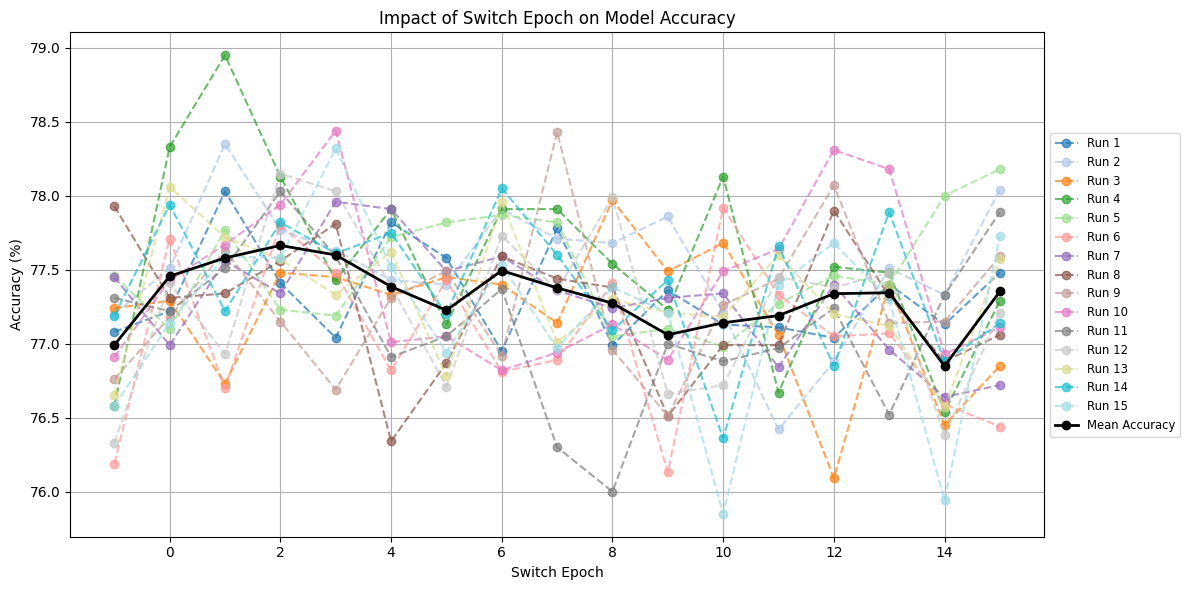

In [3]:
switch_epochs = [-1] + list(range(epochs+1))
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(np.linspace(0, 1, runs))
for run in range(runs):
    plt.plot(switch_epochs, run_accuracies[run], marker='o', linestyle='dashed', label=f'Run {run + 1}', color=colors[run], alpha=0.7)

mean_accuracies = np.mean(run_accuracies, axis=0)

plt.plot(switch_epochs, mean_accuracies, marker='o', linestyle='solid', color='black', linewidth=2, label='Mean Accuracy')

plt.xlabel('Switch Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Impact of Switch Epoch on Model Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.grid()
plt.show()

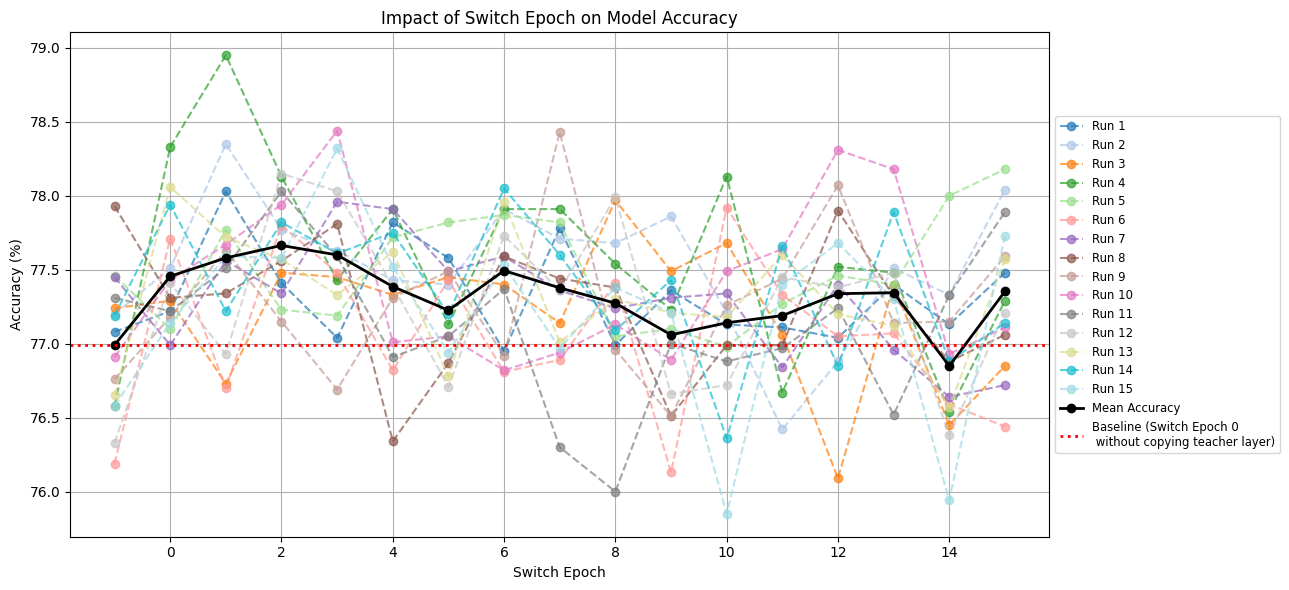

In [4]:
switch_epochs = [-1] + list(range(epochs+1))
plt.figure(figsize=(13, 6))
colors = plt.cm.tab20(np.linspace(0, 1, runs))
for run in range(runs):
    plt.plot(switch_epochs, run_accuracies[run], marker='o', linestyle='dashed', label=f'Run {run + 1}', color=colors[run], alpha=0.7)

mean_accuracies = np.mean(run_accuracies, axis=0)

plt.plot(switch_epochs, mean_accuracies, marker='o', linestyle='solid', color='black', linewidth=2, label='Mean Accuracy')
plt.axhline(y=mean_accuracies[0], color='red', linestyle='dotted', linewidth=2, label='Baseline (Switch Epoch 0\n without copying teacher layer)')

plt.xlabel('Switch Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Impact of Switch Epoch on Model Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import os

save_dir = "experiment16_run_accuracies"
os.makedirs(save_dir, exist_ok=True)
for i, run in enumerate(run_accuracies):
    filename = os.path.join(save_dir, f"run_{i + 1}.txt")
    np.savetxt(filename, np.array(run), fmt="%.4f")

np.savetxt(f"{save_dir}/mean_accuracies.txt", mean_accuracies, fmt="%.4f")